In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 3.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619420 sha256=6d04448d3b624e90c743ba2635ced3d4f9f6f0e2f0315b3209183d68b7288438
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
print("IMPORT COMPLETE")

IMPORT COMPLETE


In [ ]:
#LOAD DATASET
steam = pd.read_csv("/content/drive/MyDrive/Dataset/update_steam/steam.csv")
tag = pd.read_csv("/content/drive/MyDrive/Dataset/update_steam/steamspy_tag_data.csv")
description = pd.read_csv("/content/drive/MyDrive/Dataset/update_steam/steam_description_data.csv")

# **Content Based Recommend**

In [ ]:
steam.head(1)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,11/1/2000,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19


In [ ]:
description.head(3)

,steam_appid,detailed_description,about_the_game,short_description
0,10,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...
1,20,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...
2,30,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...


In [ ]:
# Merge about_the_game columns in description with steam data
dp1 = description[["steam_appid","about_the_game"]]
dp1.columns = ["appid", "about_the_game"]
original_df = pd.merge(steam,dp1, how ="left", on = "appid")
original_df.head(1)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,about_the_game
0,10,Counter-Strike,11/1/2000,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,Play the world's number 1 online action game. ...


In [ ]:
# df = original_df.sample(frac=0.75)
# df = original_df[:15000]
df = original_df[:10000]
print(len(original_df)," | ",len(df))

27075  |  10000


In [ ]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df.index, index=df['name']).drop_duplicates()
indices.head(10)

name
Counter-Strike                   0
Team Fortress Classic            1
Day of Defeat                    2
Deathmatch Classic               3
Half-Life Opposing Force         4
Ricochet                         5
Half-Life                        6
Counter-Strike Condition Zero    7
Half-Life Blue Shift             8
Half-Life 2                      9
dtype: int64

In [ ]:
# MERGE about_the_game WITH steamspy_tags
# MERGE developer,publisher, categories, steamspy_tags
# df['soup'] = df['about_the_game'] + df['steamspy_tags'].str.replace(';',' ')
# df['soup'] = df['steamspy_tags'].str.replace(';',' ')
# df['soup'] = df['steamspy_tags'].str.replace(';',' ') + df['about_the_game']
df['soup'] = df['developer']+" "+df['publisher']+" "+df['categories'].str.replace(';',' ') + df['steamspy_tags'].str.replace(';',' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df['soup'][0]

'Valve Valve Multi-player Online Multi-Player Local Multi-Player Valve Anti-Cheat enabledAction FPS Multiplayer'

In [ ]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english')
# count_matrix = count.fit_transform(df['about_the_game'])
count_matrix = count.fit_transform(df['soup'])

In [ ]:
count_matrix.shape

(10000, 8876)

In [ ]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most game movies
    sim_scores = sim_scores[1:11]
    # Get the movie indices
    game_indices = [i[0] for i in sim_scores]
    # Return the top 10 most game movies
    result = df.iloc[game_indices]
    #Sort by positive ratings
    # result = df.iloc[game_indices].sort_values(by='positive_ratings', ascending=False)
    
    return result[['name', 'positive_ratings','price']]

In [ ]:
get_recommendations("NARUTO Ultimate Ninja STORM")

,name,positive_ratings,price
4838,NARUTO SHIPPUDEN Ultimate Ninja STORM 4,17336,24.99
1696,NARUTO SHIPPUDEN Ultimate Ninja STORM 3 Full B...,8209,14.99
2495,NARUTO SHIPPUDEN Ultimate Ninja STORM Revolution,4152,19.99
1730,PAC-MAN MUSEUM,120,14.99
4823,Saint Seiya Soldiers' Soul,1588,39.99
4472,Grand Class Melee 2,32,5.49
6360,TEKKEN 7,15372,34.99
9093,Super ComboMan Smash Edition,2,10.99
3901,DRAGON BALL XENOVERSE,12601,31.99
7528,One Piece Burning Blood,1504,39.99


In [ ]:
get_recommendations("Counter-Strike")

,name,positive_ratings,price
1,Team Fortress Classic,3318,3.99
3,Deathmatch Classic,1273,3.99
5,Ricochet,2758,3.99
7,Counter-Strike Condition Zero,12120,7.19
15,Half-Life Deathmatch Source,1362,0.00
6,Half-Life,27755,7.19
13,Half-Life 2 Deathmatch,6020,3.99
2,Day of Defeat,3416,3.99
4,Half-Life Opposing Force,5250,3.99
2991,Call of Duty Infinite Warfare,7821,39.99


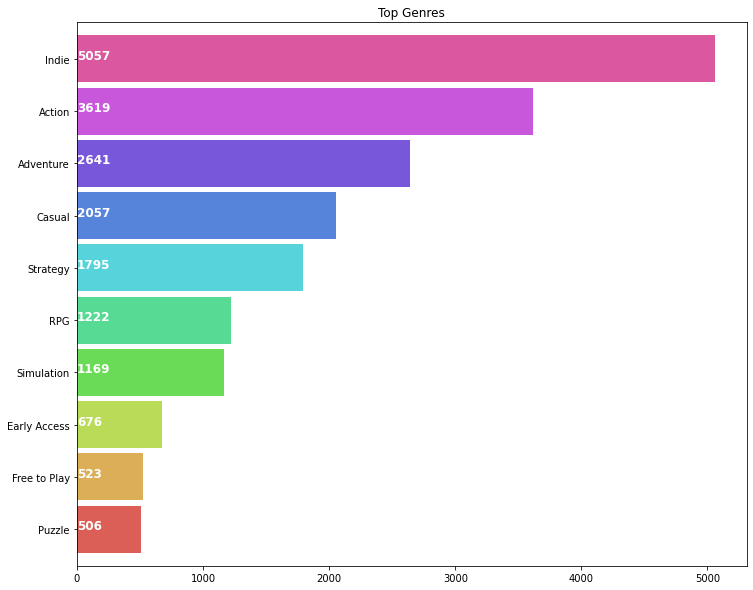

In [ ]:
a = df['steamspy_tags'].str.split(';')
list1 = []
for i in a:
    list1.extend(i)
plt.subplots(figsize=(12,10))
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

In [ ]:
pd.Series(list1).value_counts()

Indie           5057
Action          3619
Adventure       2641
Casual          2057
Strategy        1795
                ... 
Old School         1
3D                 1
Snowboarding       1
Parody             1
Cartoony           1
Length: 306, dtype: int64

# Collaborative Filtering

In [ ]:
orginal_rating = pd.read_csv("/content/drive/MyDrive/Dataset/update_steam/final_sample.csv")
orginal_rating.head(3)

,UserId,name,appid,status,value
0,5250,Alien Swarm,630.0,purchase,1.0
1,5250,Alien Swarm,630.0,play,4.9
2,5250,Cities Skylines,255710.0,purchase,1.0


In [ ]:
# Remove status play row
rating = orginal_rating[orginal_rating['status'] == 'play'].drop(['status'], axis = 1)
rating['appid'] = rating['appid'].astype(int)
rating.head(10)

,UserId,name,appid,value
1,5250,Alien Swarm,630,4.9
3,5250,Cities Skylines,255710,144.0
9,5250,Dota 2,570,0.2
20,5250,Portal 2,620,13.6
23,5250,Team Fortress 2,440,0.8
26,76767,Alien Swarm,630,0.8
30,76767,Banished,242920,24.0
32,76767,Call of Duty Black Ops,42700,22.0
34,76767,Call of Duty Modern Warfare 2,10180,65.0
36,76767,Call of Duty World at War,10090,271.0


In [ ]:
rating['value'].sort_values(ascending=True)

106755        0.1
38507         0.1
38525         0.1
38536         0.1
38566         0.1
           ...   
39051      6964.0
90182      7765.0
99107      9640.0
73740     10442.0
56198     11754.0
Name: value, Length: 52165, dtype: float64

In [ ]:
reader = Reader()
data = Dataset.load_from_df(rating[['UserId', 'appid','value']], reader)

In [ ]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv = 5, verbose=0)

{'fit_time': (2.522118330001831,
  2.5690340995788574,
  2.5822715759277344,
  2.4486873149871826,
  2.461613178253174),
 'test_mae': array([50.55028276, 54.4241733 , 52.64504936, 56.46915556, 52.92998179]),
 'test_rmse': array([241.83600858, 268.99774226, 264.73453459, 280.62142788,
        242.30894503]),
 'test_time': (0.15235137939453125,
  0.08854222297668457,
  0.0966787338256836,
  0.18162250518798828,
  0.08418416976928711)}

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
svd.predict(76767, 100,3)
# a.est

Prediction(uid=76767, iid=100, r_ui=3, est=5, details={'was_impossible': False})

# Hybrid Recommender

In [ ]:
df.head(1)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,about_the_game,soup
0,10,Counter-Strike,11/1/2000,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,Play the world's number 1 online action game. ...,Valve Valve Multi-player Online Multi-Player L...


In [ ]:
def hybrid(userId, title):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar game
    sim_scores = sim_scores[1:26]
    game_indices = [i[0] for i in sim_scores]
    result = df.iloc[game_indices]
    result['sim_scores'] = sim_scores
    result['est'] = result['appid'].apply(lambda x: svd.predict(userId, x).est)
    result = result.sort_values('est', ascending=False)
    return result.head(10)

In [ ]:
hybrid(76767,'NARUTO SHIPPUDEN Ultimate Ninja STORM 4')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,about_the_game,soup,sim_scores,est
2495,272510,NARUTO SHIPPUDEN Ultimate Ninja STORM Revolution,9/15/2014,1,"CyberConnect2 Co., Ltd.",BANDAI NAMCO Entertainment,windows,0,Single-player;Multi-player;Steam Achievements;...,Action;Adventure,Anime;Fighting;Ninja,50,4152,995,969,1434,200000-500000,19.99,<strong>THE REVOLUTIONARY STORM SERIES RETURNS...,"CyberConnect2 Co., Ltd. BANDAI NAMCO Entertain...","(2495, 0.9435641951204966)",5
1584,226780,MUD Motocross World Championship,3/15/2013,1,Milestone S.r.l.,BANDAI NAMCO Entertainment,windows,0,Single-player;Multi-player;Steam Achievements;...,Racing;Sports,Motocross;Racing;Motorbike,50,42,44,0,0,20000-50000,7.99,The only videogame that exclusively features t...,Milestone S.r.l. BANDAI NAMCO Entertainment Si...,"(1584, 0.7703288865196434)",5
7860,434790,Planet 1138,2/18/2016,1,Bionic Pony,Triskelia Games,windows,0,Single-player;Multi-player;Steam Achievements;...,Action;Indie;Strategy,Strategy;Action;Indie,18,11,4,0,0,0-20000,1.99,Planet 1138 is a vehicle based action game wit...,Bionic Pony Triskelia Games Single-player Mult...,"(7860, 0.7548513560963972)",5
943,57900,Duke Nukem Forever,6/9/2011,1,Gearbox Software,2K,windows;mac,18,Single-player;Multi-player;Steam Achievements;...,Action,FPS;Action;Nudity,62,4433,2243,434,472,1000000-2000000,14.99,"The King is Back!<br><br>\t\t\t\t\t\tCocked, l...",Gearbox Software 2K Single-player Multi-player...,"(943, 0.7548513560963972)",5
9323,482450,Nitroplus Blasterz Heroines Infinite Duel,12/8/2016,1,EXAMU,"XSEED Games;Marvelous USA, Inc.;Marvelous",windows,0,Single-player;Multi-player;Online Multi-Player...,Action,Anime;Fighting;Action,51,375,46,198,198,20000-50000,14.99,"EXAMU, the developers behind the popular <i>Ar...","EXAMU XSEED Games;Marvelous USA, Inc.;Marvelou...","(9323, 0.7614996105085897)",5
4099,330180,Pix the Cat,1/29/2015,1,Pastagames,Focus Home Interactive,windows;mac;linux,0,Single-player;Multi-player;Steam Achievements;...,Action;Indie,Indie;Action;Cats,11,239,60,247,247,50000-100000,6.99,"<i>“In Pix the Cat, you are Pix, the first cat...",Pastagames Focus Home Interactive Single-playe...,"(4099, 0.7624425757515653)",5
3332,303830,Motorcycle Club,11/28/2014,1,Kylotonn Entertainment,Bigben Interactive;Plug In Digital,windows,0,Single-player;Multi-player;Steam Achievements;...,Racing,Racing,50,16,52,0,0,0-20000,6.99,"<h2 class=""bb_tag"">THE RIDE OF YOUR LIFE</h2><...",Kylotonn Entertainment Bigben Interactive;Plug...,"(3332, 0.7624425757515653)",5
5988,378860,Project CARS 2,9/21/2017,1,Slightly Mad Studios,BANDAI NAMCO Entertainment,windows,0,Single-player;Multi-player;Online Multi-Player...,Racing,Racing;Driving;Simulation,47,4190,1747,121,169,200000-500000,44.99,FEATURES: <br>• 180+ elite- brand race &amp; r...,Slightly Mad Studios BANDAI NAMCO Entertainmen...,"(5988, 0.7624425757515654)",5
8031,439910,Risky Rescue,2/19/2016,1,Digital Melody,Forever Entertainment S. A.,windows;mac;linux,0,Single-player;Multi-player;Cross-Platform Mult...,Action;Casual;Indie,Casual;Action;Indie,9,248,62,209,245,50000-100000,0.79,New game from the creators of award winning Ti...,Digital Melody Forever Entertainment S. A. Sin...,"(8031, 0.7635417155709334)",5
3441,307780,Mortal Kombat X,4/13/2015,1,NetherRealm Studios;QLOC,Warner Bros. Interactive Entertainment,windows,18,Single-player;Multi-player;Steam Achievements;...,Action,Fighting;Gore;Action,73,21484,7154,1030,446,1000000-2000000,15.99,Who’s Next? Experience the Next Generation of...,NetherRealm Studios;QLOC Warner Bros. Interact...,"(3441, 0.7635417155709334)",5
